In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features, transform_features2Xdict, MultiOutputSeparateLassoCV
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

In [8]:
!pwd $VVS_SHARED

/n/home12/binxuwang/Github/Closed-loop-visual-insilico/notebooks


In [10]:
shared_dataroot = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/"
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") #/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
#"vvs-accentuate-day1_normalize_paul_241119.h5")
# data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5") 
data_path = join(dataroot, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
data = load_from_hdf5(data_path)
print("Subjects:", list(data.keys()))
# subjects: ['paul_20241119', 'paul_241119']
subject_id = 'red_20241212-20241220' #'paul_20241119'
data_dict = load_neural_data(data_path, subject_id=subject_id, stimroot=stimroot)
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])

Subjects: ['red_20241212-20241220']
Trials shape: (28677,) (28677, 64)
Rspavg shape: (1028,) (1028, 64)
Response tensor shape (stimulus x neuron x trial): (1028, 64, 36)
Response tensor shape: (1028, 64, 36)
Trial counters shape: (1028,)
min and max trial counters: 22 36
All stimulus files were found


In [ ]:
pilotroot = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")

In [13]:
!ls {join(dataroot, "model_outputs")}/paul_20241119/*_Xtfmer_RidgeCV.pkl

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_dino_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl


In [11]:
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [17]:

def compute_D2_per_unit(rspavg_resp_peak, rspavg_pred):
    return 1 - np.square(rspavg_resp_peak - rspavg_pred).sum(axis=0) / np.square(rspavg_resp_peak - rspavg_resp_peak.mean(axis=0)).sum(axis=0)


def compute_model_predictions_and_D2(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel, idx_train, idx_test):
    """
    Compute predictions and D2 scores for fitted models.
    
    Args:
        fit_models_lyrswp: Dictionary of fitted models
        Xdict_lyrswp: Dictionary of feature matrices
        resp_mat_sel: Response matrix
        idx_train: Training indices
        idx_test: Test indices
        
    Returns:
        pred_dict: Dictionary of predictions
        D2_per_unit_dict: Dictionary of D2 scores
        D2_per_unit_train_dict: Dictionary of training D2 scores 
        D2_per_unit_test_dict: Dictionary of test D2 scores
    """
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {} 
    D2_per_unit_dict = {}
    
    for (model_dimred, regressor) in fit_models_lyrswp.keys():
        fit_model = fit_models_lyrswp[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        
        D2_per_unit_dict[(model_dimred, regressor)] = D2_per_unit
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test
        
    return pred_dict, D2_per_unit_dict, D2_per_unit_train_dict, D2_per_unit_test_dict

In [28]:
def plot_D2_vs_ncsnr_perlayer(D2_per_unit_test_dict, D2_per_unit_train_dict, ncsnr, subject_id, modelname, ):
    """Plot D2 scores vs neural signal-to-noise ratio for each model/regressor combination.
    
    Args:
        D2_per_unit_test_dict: Dictionary of test D2 scores
        D2_per_unit_train_dict: Dictionary of training D2 scores
        ncsnr: Neural signal-to-noise ratio values
        subject_id: Subject identifier
        modelname: Name of model
        figdir: Directory to save figures
    """
    n_combinations = len(D2_per_unit_test_dict.keys())
    figh, axs = plt.subplots(3, n_combinations//3, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.ylabel("D2 per unit")
        plt.legend()
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    plt.show()
    return figh


def plot_layer_sweep_results(result_df_lyrswp, subject_id, modelname, ):
    """Plot training and test R2 scores across layers.
    
    Args:
        result_df_lyrswp: DataFrame containing regression results
        subject_id: Subject identifier  
        modelname: Name of model
        figdir: Directory to save figures
    """
    # Format results dataframe
    result_df_lyrswp_formatted = result_df_lyrswp.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    
    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    plt.show()
    return result_df_lyrswp_formatted, figh

In [32]:
idx_train, idx_test = train_test_split(
    np.arange(len(rspavg_resp_peak)), test_size=0.2, random_state=42, shuffle=True
)

dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "Stimuli", "shared1000") 
pilot_MACO_root = join(dataroot, "Stimuli", "stimuli_pilot_20241119", "results")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
subject_id = 'red_20241212-20241220'
PCA_subject_id = 'red_20241212-20241220' # 'paul_20241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
stim_names = data_dict['stimulus_names']
image_fps = parse_image_fullpaths(stim_names, [stimroot, pilot_MACO_root])
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figroot = join(dataroot, "model_outputs")
figdir = join(dataroot, "model_outputs", subject_id+"_Lasso", )
os.makedirs(figdir, exist_ok=True)
for modelname in ["resnet50_robust", ]: # "resnet50", "resnet50_clip", "resnet50_dino",  
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    # Select layers, here we choose all the blocks in layer4 
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if PCA_subject_id is not None and \
        os.path.exists(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl")):
        Xtfmer_lyrswp = th.load(join(figroot, PCA_subject_id, f"{PCA_subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"), )
    else:
        Xtfmer_lyrswp = {}
        
    Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", ],  #  "srp"
                                    pretrained_Xtransforms=Xtfmer_lyrswp)
    # Define regressors
    regressors = [MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                  MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                  RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                  ] 
    regressor_names = ["MultiTaskLassoCV", "MultiOutputSeparateLassoCV", "RidgeCV"]
    result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeLassoCV.pth")) 
    th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"))

    pred_dict, D2_per_unit_dict, D2_per_unit_train_dict, D2_per_unit_test_dict = compute_model_predictions_and_D2(
                                    fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel, idx_train, idx_test)
    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta_RidgeLassoCV.pkl"), "wb"))

    figh = plot_D2_vs_ncsnr_perlayer(D2_per_unit_test_dict, D2_per_unit_train_dict, ncsnr, subject_id, modelname, )
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter_RidgeLassoCV")
    
    result_df_lyrswp_formatted, figh2 = plot_layer_sweep_results(result_df_lyrswp, subject_id, modelname, )
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_RidgeLassoCV")
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV_formatted.csv"))
    

All stimulus files were found
Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_red_20241212-20241220.h5
Fitting models for subject red_20241212-20241220 with resnet50_robust model | 64 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

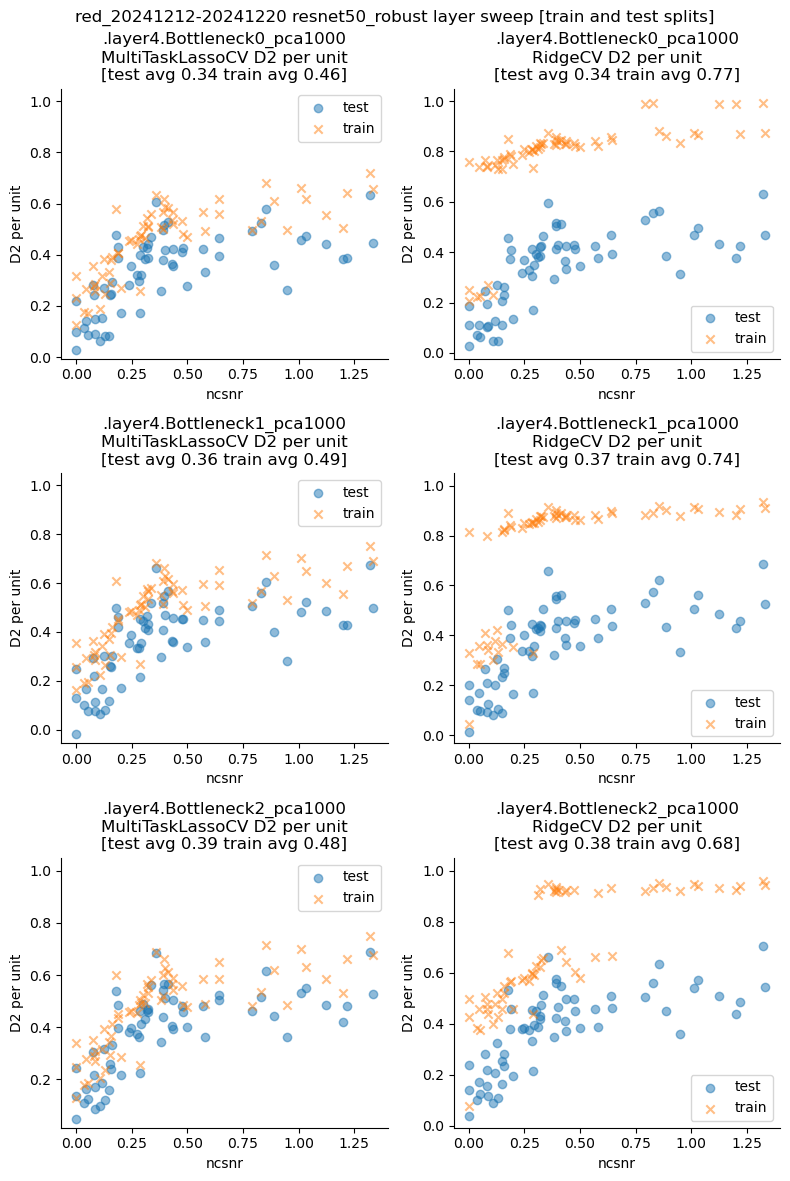

<Figure size 640x480 with 0 Axes>

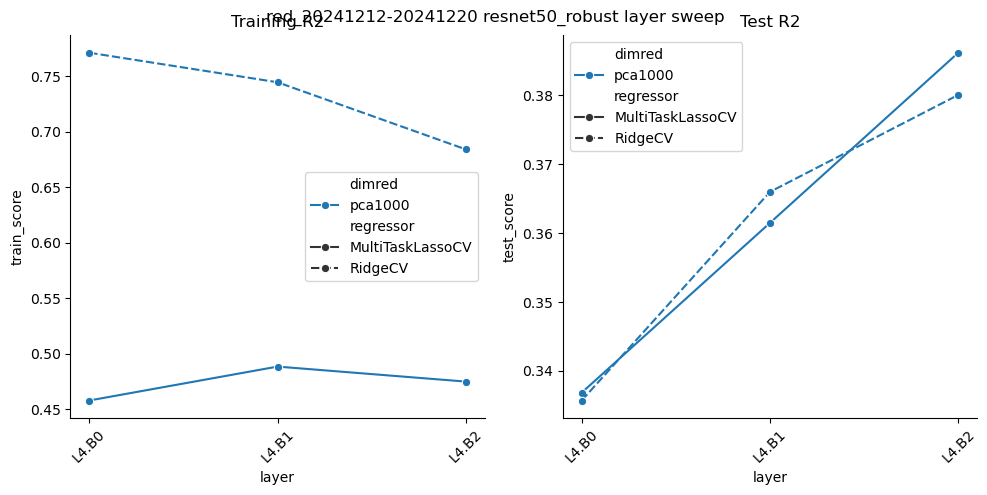

<Figure size 640x480 with 0 Axes>

In [26]:

figh = plot_D2_vs_ncsnr_perlayer(D2_per_unit_test_dict, D2_per_unit_train_dict, ncsnr, subject_id, modelname, )
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter_RidgeLassoCV")

result_df_lyrswp_formatted, figh2 = plot_layer_sweep_results(result_df_lyrswp, subject_id, modelname, )
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_RidgeLassoCV")
result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV_formatted.csv"))


### Democratics R2 and Layer selection

Text(0, 0.5, 'D2 per unit (resnet50)')

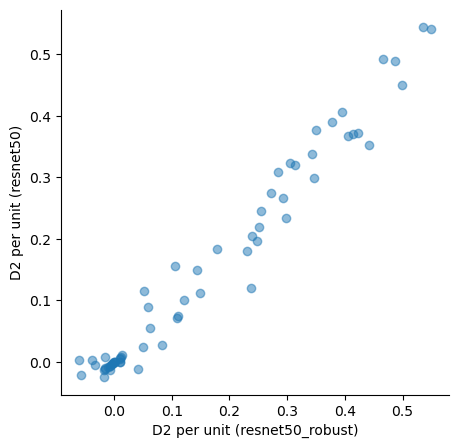

In [27]:
modelname1 = "resnet50_robust"
modelname2 = "resnet50"
pred_meta1 = pkl.load(open(join(figdir, f"{subject_id}_{modelname1}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
pred_meta2 = pkl.load(open(join(figdir, f"{subject_id}_{modelname2}_sweep_regressors_layers_pred_meta.pkl"), "rb"))

target_key1 = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
target_key2 = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
D2_per_unit_test_dict1 = pred_meta1["D2_per_unit_test_dict"][target_key1]
D2_per_unit_test_dict2 = pred_meta2["D2_per_unit_test_dict"][target_key2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.sca(ax)
plt.scatter(D2_per_unit_test_dict1, D2_per_unit_test_dict2, alpha=0.5)
plt.xlabel(f"D2 per unit ({modelname1})")
plt.ylabel(f"D2 per unit ({modelname2})")


In [30]:
# top 5 indices
top5_idx1 = np.argsort(D2_per_unit_test_dict1)[-5:][::-1]
print(modelname1, top5_idx1, D2_per_unit_test_dict1[top5_idx1].mean(), D2_per_unit_test_dict1[top5_idx1])
top5_idx2 = np.argsort(D2_per_unit_test_dict2)[-5:][::-1]
print(modelname2, top5_idx2, D2_per_unit_test_dict2[top5_idx2].mean(), D2_per_unit_test_dict2[top5_idx2])
assert set(top5_idx1) == set(top5_idx2)

resnet50_robust [40  8 25 36 47] 0.507037939662701 [0.54954231 0.53463111 0.49814485 0.48683062 0.46604081]
resnet50 [ 8 40 47 36 25] 0.5031477359053274 [0.54431758 0.54160451 0.49205645 0.48846041 0.44929973]


In [31]:
# top 5 indices
topk = 5
top5_idx1 = np.argsort(D2_per_unit_test_dict1)[-topk:]
print(modelname1, target_key1, top5_idx1, D2_per_unit_test_dict1[top5_idx1].mean(), D2_per_unit_test_dict1[top5_idx1])
top5_idx2 = np.argsort(D2_per_unit_test_dict2)[-topk:]
print(modelname2, target_key2, top5_idx2, D2_per_unit_test_dict2[top5_idx2].mean(), D2_per_unit_test_dict2[top5_idx2])
assert set(top5_idx1) == set(top5_idx2)

resnet50_robust ('.layer4.Bottleneck1_pca1000', 'RidgeCV') [47 36 25  8 40] 0.5070379396627012 [0.46604081 0.48683062 0.49814485 0.53463111 0.54954231]
resnet50 ('.layer4.Bottleneck1_pca1000', 'RidgeCV') [25 36 47 40  8] 0.5031477359053274 [0.44929973 0.48846041 0.49205645 0.54160451 0.54431758]


In [32]:
figdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119-20241122'

### Export models

In [36]:
!ls /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122

paul_20241119  paul_20241119-20241122


In [38]:
outputdir = f"/n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/{subject_id}"
os.makedirs(outputdir, exist_ok=True)

In [39]:
for modelname in ["resnet50_robust", "resnet50"]:
    fit_models_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth"))
    Xtfmer_lyrswp_RidgeCV = th.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), "rb"))
    result_df_lyrswp_RidgeCV = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    pred_data = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))

    key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
    readout_path = join(outputdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
    Xtransform_path = join(outputdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
    meta_path = join(outputdir, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl")

    regressor = fit_models_lyrswp_RidgeCV[key]
    Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
    pred_rsp = pred_data["pred_dict"][key]
    D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
    D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]

    readout = LinearLayer_from_sklearn(regressor)
    th.save(readout.state_dict(), readout_path)
    pkl.dump(Xtfmer, open(Xtransform_path, "wb"))
    th.save({
        "reliability": reliability,
        "ncsnr": ncsnr,
        "D2_per_unit_test": D2_per_unit_test,
        "D2_per_unit_train": D2_per_unit_train
    }, meta_path)
    print(f"Saved {readout_path}")
    print(f"Saved {Xtransform_path}")
    print(f"Saved {meta_path}")

Saved /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122/paul_20241119-20241122_resnet50_robust_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth
Saved /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122/paul_20241119-20241122_resnet50_robust_sweep_regressors_Xtfmer_RidgeCV_.layer4.Bottleneck1_pca1000.pkl
Saved /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122/paul_20241119-20241122_resnet50_robust_sweep_regressors_meta_RidgeCV_.layer4.Bottleneck1_pca1000.pkl
Saved /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122/paul_20241119-20241122_resnet50_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth
Saved /n/holylabs/LABS/kempner_fellows/Lab/neural_regress_weights_BW/paul_20241119-20241122/paul_20241119-20241122_resnet50_sweep_regressors_Xtfmer_RidgeCV_.layer4.Bottleneck1_pca1000.pkl
Saved /n/holylabs/LABS/kempner_fellows/

### Neural pixel array fitting

In [49]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id = 'paul_241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
for modelname in ["resnet50_robust", "resnet50", "resnet50_clip", "resnet50_dino", ]: # 
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if os.path.exists(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl")):
        Xtfmer_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), )
    else:
        Xtfmer_lyrswp_RidgeCV = {}
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    
    # summarize prediction and evaluation
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {}
    D2_per_unit_dict = {}
    for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
        fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
        # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

    figh, axs = plt.subplots(3, 2, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.legend()
        plt.ylabel("D2 per unit")
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
    plt.show()
    
    
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))


    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()

Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_paul_241119.h5
Fitting models for subject paul_241119 with resnet50_robust model | 383 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=383
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.075 D2_test: 0.001
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.080 D2_test: 0.002
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.072 D2_test: 0.001
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.076 D2_test: 0.001
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.065 D2_test: 0.001
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.068 D2_test: 0.001
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [1000000000.0, 1000000000.0, 1000000.0, 100000...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000

ValueError: operands could not be broadcast together with shapes (1028,64) (1028,383) 

### Evaluate the fits separately

In [44]:
rspavg_pred

array([[0.46502571, 0.530665  , 0.48078774, ..., 0.63191901, 0.29132967,
        0.49452008],
       [0.57262446, 0.47385085, 0.47955196, ..., 0.54764787, 0.3751547 ,
        0.51015929],
       [0.60387989, 0.66790043, 0.48071936, ..., 0.53858882, 0.40156122,
        0.49245193],
       ...,
       [1.62651854, 0.84501692, 0.47962383, ..., 0.41660494, 0.6354187 ,
        0.5789594 ],
       [1.66385962, 1.25584118, 0.48505274, ..., 0.3926906 , 0.7912529 ,
        0.55886755],
       [2.2149652 , 0.99234585, 0.49847044, ..., 0.45830786, 0.69148003,
        0.51728337]])

In [31]:
pred_dict = {}
D2_per_unit_train_dict = {}
D2_per_unit_test_dict = {}
for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
    fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
    Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
    # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
    rspavg_pred = fit_model.predict(Xfeat)
    pred_dict[(model_dimred, regressor)] = rspavg_pred
    D2_per_unit_train = compute_D2_per_unit(rspavg_resp_peak[idx_train], rspavg_pred[idx_train])
    D2_per_unit_test = compute_D2_per_unit(rspavg_resp_peak[idx_test], rspavg_pred[idx_test])
    D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
    D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

pkl.dump({
    "pred_dict": pred_dict,
    "D2_per_unit_train_dict": D2_per_unit_train_dict,
    "D2_per_unit_test_dict": D2_per_unit_test_dict,
}, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.legend()
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
plt.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
plt.show()

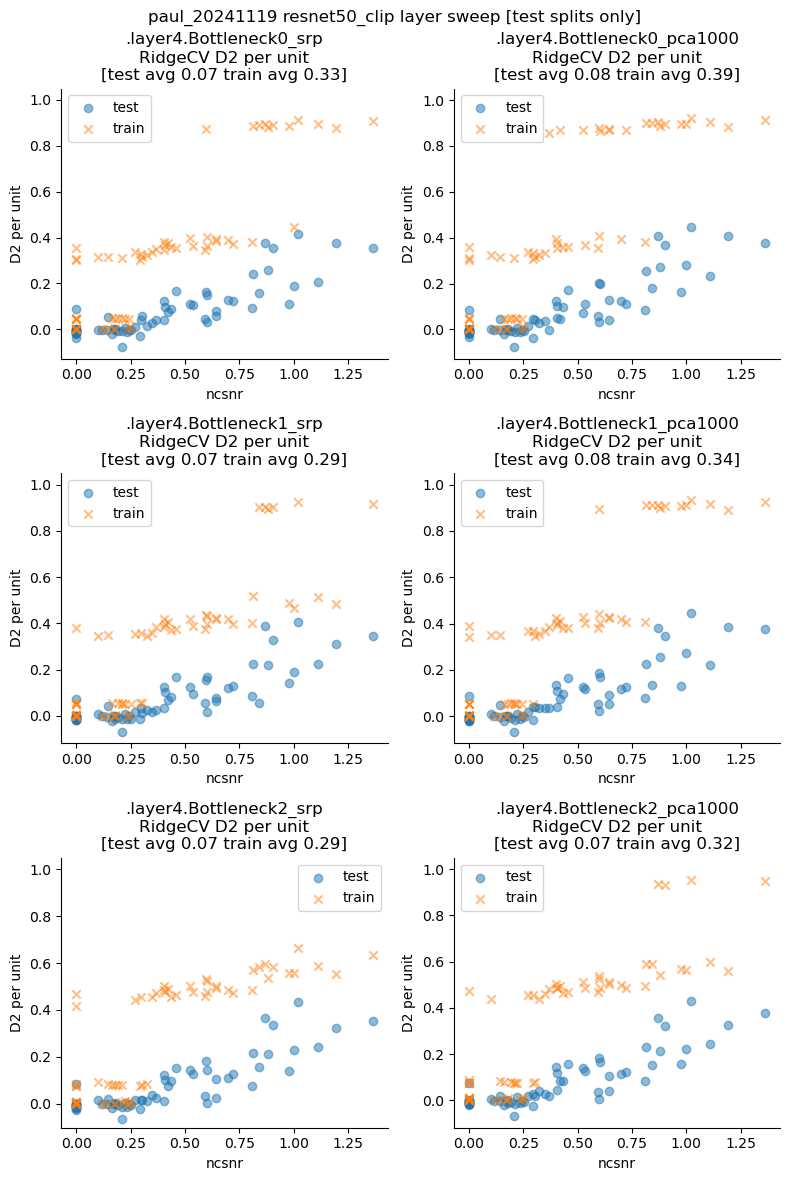

In [42]:
figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.legend()
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [test splits only]")
plt.tight_layout()
plt.show()

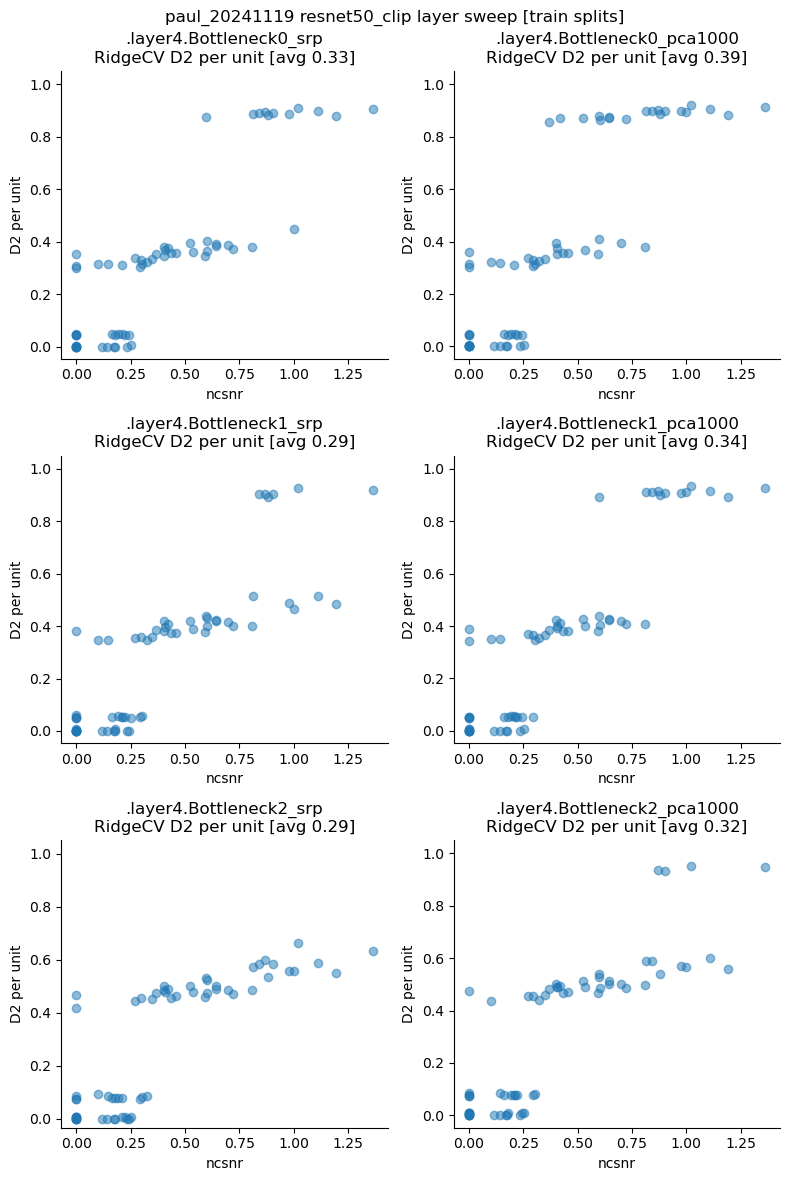

In [38]:
figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_train_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="o", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit [avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [train splits]")
plt.tight_layout()
plt.show()

In [ ]:
# !cd /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation
!for file in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/stimuli_pilot_20241119/results/*; do
    ln -sf "$file" shared1000
done

In [6]:
data_dict

{'brain_area': array([b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT'], dtype=object),
 'ncsnr': array([0.8082842 , 0.5987334 , 0.        , 0.7216381 , 0.14398432,
        0.8402192 , 0.9996467 , 1.1090726 , 0.86786723, 0.5246871 ,
        0.25285387, 0.40623817, 0.11611781, 0.3684164 , 0.29429722,
        0.593332  , 0.2720084

Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > -1 N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.323 D2_test: 0.075
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.398 D2_test: 0.082
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.352 D2_test: 0.069
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.415 D2_test: 0.081
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.339 D2_test: 0.062
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.414 D2_test: 0.075
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [100000.0, 100000.0, 10000000.0, 100000.0, 100...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000.0,

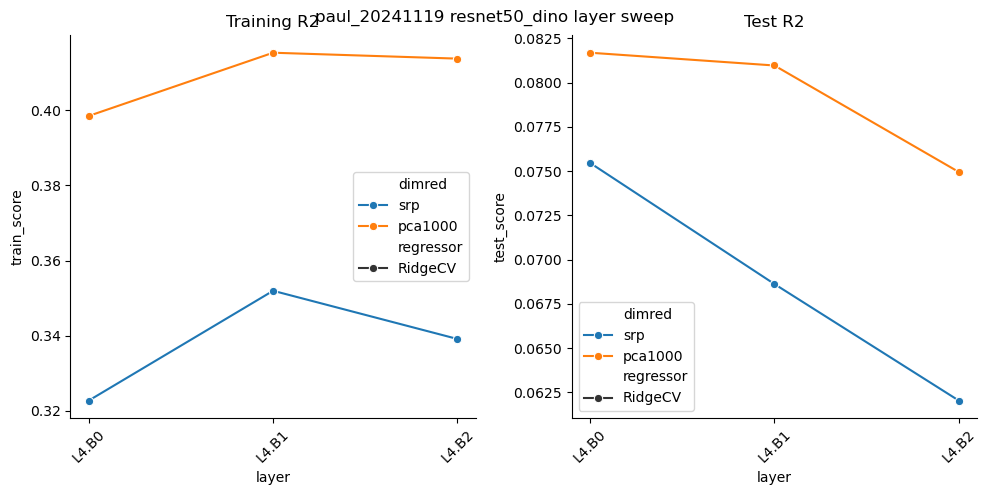

In [ ]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119-241122.h5")
subject_id = 'paul_20241119-20241122'
batch_size = 96 
device = "cuda" 
reliability_thresh = -1
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
# raise ValueError("stop here")
for modelname in ["resnet50_robust", "resnet50", ]: # "resnet50_clip", "resnet50_dino", 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Load data
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))


    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()